# Pre-Trained Convolutional Neural Network loading and testing

In [1]:
# Imports and setup
# OS File manipulation
import os
import glob
import csv

# Math
import numpy as np
import math
import scipy.stats

# Image processing
import cv2

# Plotting
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Programming tools
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

# Neural Networks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split

# Wide jupyter cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Tensorflow GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Preparation

In [2]:
# Builds a structured numpy array containing the dataset
# (images, radiance values, gps coordinates and pixel coordinates in the original nightlight image)

dataset_dt = dtype=[('image', 'float32', (50, 50, 3)), ('radiance', 'float32'), ('radiance_predicted', 'float32'), ('gps', 'float32', (2,)), ('pixels', 'int32', (2,))]

def get_dataset(img_dir):
    data_path = os.path.join(img_dir, '*.png')
    files = glob.glob(data_path)
    
    dataset = np.zeros(len(files), dataset_dt)
    dataset['radiance_predicted'] -= 1.0
    
    for i, file in enumerate(tqdm(files)):
        # Read image
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        filename = file.split('\\')[-1]
        metadata = filename.split('_')
        
        radiance_str = metadata[2].split('.')[0]
        gps_str = metadata[0][1:-1].split(',')
        pixels_str = metadata[1].split('x')
        
        radiance = int(radiance_str)
        gps = tuple(map(lambda x: float(x), gps_str))
        pixels = tuple(map(lambda x: float(x), pixels_str))
        
        dataset['image'][i]    = img
        dataset['radiance'][i] = radiance
        dataset['gps'][i]      = gps
        dataset['pixels'][i]   = pixels
        
    return dataset

In [3]:
dataset = get_dataset("data\\sentinel2\\splits\\sokoto")

  0%|          | 0/417392 [00:00<?, ?it/s]

In [4]:
max_radiance = np.percentile(dataset['radiance'], 99.999)
print(f'Clipped max radiance: {max_radiance}')

Clipped max radiance: 178.0


In [5]:
np.clip(dataset['radiance'], 0, max_radiance, out=dataset['radiance'])

array([3., 3., 0., ..., 0., 0., 0.], dtype=float32)

In [6]:
# Normalize datasets
dataset_norm = np.copy(dataset)
dataset_norm['image'] = dataset['image'] / 255.0
dataset_norm['radiance'] = dataset['radiance'] / max_radiance

In [7]:
# Displays info about one element of the dataset
def show_data(data, max_radiance):
    
    predicted = None if data["radiance_predicted"] < 0 else f'{data["radiance_predicted"] * max_radiance} ({data["radiance_predicted"]})'
    
    print(f'Radiance: {data["radiance"] * max_radiance}/{max_radiance} ({data["radiance"]}/1.0)')
    print(f'Predicted radiance: {predicted}')
    print(f'GPS: {data["gps"][1]}N {data["gps"][0]}E')
    print(f'Nightlight pixels: {data["pixels"]}')
    plt.imshow(data["image"])
    
# Displays info about one element of the dataset
# having a radiance of a certain level or more
def show_for_radiance(dataset, max_radiance, radiance=None, radiance_normalized=None):
    threshold, factor = (radiance, max_radiance) if radiance_normalized == None else (radiance_normalized, 1.0)
    
    for data in dataset:
        if data['radiance'] * factor >= threshold:
            show_data(data, max_radiance)
            break

Radiance: 50.999998450279236/178.0 (0.28651684522628784/1.0)
Predicted radiance: None
GPS: 13.633333206176758N 4.0333333015441895E
Nightlight pixels: [ 968 1528]


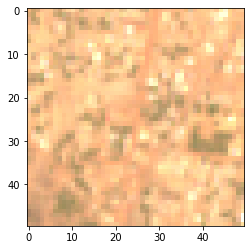

In [8]:
show_for_radiance(dataset_norm, max_radiance, radiance = 50)

In [9]:
def histogram(data, title='Data', xlabel='Radiance value', ylabel='# Appearances', yscale='log', bins=100):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))    
    
    ax.hist(data, bins=bins)
    ax.grid(True)
    ax.set_yscale(yscale)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def compare_radiance_histogram(data1, data2, title1='Data 1', title2='Data 2', xlabel='Radiance value', ylabel='# Appearances', yscale='log', bins=100):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))    
    
    ax1.hist(data1, bins=bins)
    ax1.grid(True)
    ax1.set_yscale(yscale)
    ax1.set_title(title1)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    
    ax2.hist(data2, bins=bins)
    ax2.grid(True)
    ax2.set_yscale(yscale)
    ax2.set_title(title2)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)

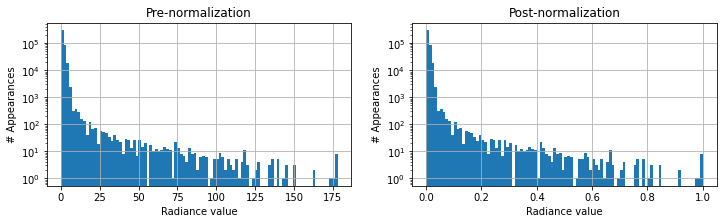

In [10]:
# Compare radiance distribution before and after normalization
compare_radiance_histogram(dataset['radiance'], dataset_norm['radiance'], 'Pre-normalization', 'Post-normalization')
del dataset # save some space in RAM

In [11]:
dataset_1, dataset_2 = train_test_split(dataset_norm, test_size=0.5)

# good sokoto split: 1200
split = None

# Separating the dataset according to split, if needed
#dataset_1 = dataset_norm[dataset_norm['pixels'][:,0] < split]
#dataset_2 = dataset_norm[dataset_norm['pixels'][:,0] >= split]

print(f'Length of dataset_1: {len(dataset_1)}')
print(f'Length of dataset_2: {len(dataset_2)}')

Length of dataset_1: 208696
Length of dataset_2: 208696


# Model loading

In [13]:
model_name = "FinalV4_model_F[48, 32, 16]_D[32, 32]_SchedLR5e-05_E250_sparse_train1test2"

model = load_model(model_name)
history = np.load(f'{model_name}/history.npy', allow_pickle='TRUE').item()

model.summary()

Model: FinalV3_model_F[48, 32, 16]_D[32, 32]_SchedLR5e-05_E250_sparse_train1test2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        13856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
________________________________________

# Evaluating Model

In [16]:
def plot_loss(history):
    fig, ax = plt.subplots(1, 1)    
    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    ax.set_title('Model loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['train', 'test'], loc='upper right')
    
def plot_loss_tight(history):
    fig, ax = plt.subplots(1, 1)    
    ax.set_xlim(0, len(history['loss']))
    ax.set_ylim(min(history['loss'][1:] + history['val_loss'][1:]), 
                max(history['loss'][1:] + history['val_loss'][1:]))
    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    ax.set_title('Model loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['train', 'test'], loc='upper right')

In [17]:
def compare_same_dataset(dataset, gt_title='Ground Truth', pr_title='Predictions', amplification=1.0, sparse=False, diff=False, split=None, vmin=None, vmax=None, cmap='magma'):
    min_x = np.min(dataset["pixels"][:,0])
    max_x = np.max(dataset["pixels"][:,0])
    min_y = np.min(dataset["pixels"][:,1])
    max_y = np.max(dataset["pixels"][:,1])
    
    width = max_x - min_x
    height = max_y - min_y
    
    if not sparse:
        map_pr = np.ones((height + 1, width + 1))
        map_pr *= -np.inf
    else:
        map_pr = np.zeros((height + 1, width + 1))
    
    map_gt = np.copy(map_pr)
    
    for i, data in enumerate(dataset):
        x, y = data['pixels']
        x -= min_x
        y -= min_y
        map_gt[y, x] = data['radiance']
        map_pr[y, x] = data['radiance_predicted'] if (diff == False) else data['radiance'] - data['radiance_predicted']
        
    if split != None:
        split -= min_x
        for y in range(height):
            map_gt[y, split-1:split+2] = -np.inf
            map_pr[y, split-1:split+2] = -np.inf

    min_rad = min(np.min(dataset['radiance']), np.min(dataset['radiance_predicted'])) if vmin == None else vmin
    max_rad = max(np.max(dataset['radiance']), np.max(dataset['radiance_predicted']))/amplification  if vmax == None else vmax
    
    f, (ax1, ax2, axcb) = plt.subplots(1,3, figsize=(20, 7), gridspec_kw={'width_ratios':[1,1,0.04]})
    ax1.get_shared_y_axes().join(ax2)
    
    ax1.set_title(gt_title)
    ax2.set_title(pr_title)
    
    sns.heatmap(map_gt, vmin=min_rad, vmax=max_rad, cbar=False, ax=ax1, cmap=cmap)
    sns.heatmap(map_pr, vmin=min_rad, vmax=max_rad, ax=ax2, cbar_ax=axcb, cmap=cmap)

    plt.show()

In [18]:
def compare_two_datasets(dataset_gt, dataset_pr, gt_title='Ground Truth', pr_title='Predictions', amplification=1.0, sparse=False, diff=False, vmin=None, vmax=None, cmap='magma'):
    min_x = min(np.min(dataset_gt["pixels"][:,0]),
                np.min(dataset_pr["pixels"][:,0]))
    max_x = max(np.max(dataset_gt["pixels"][:,0]),
                np.max(dataset_pr["pixels"][:,0]))
    
    min_y = min(np.min(dataset_gt["pixels"][:,1]),
                np.min(dataset_pr["pixels"][:,1]))
    max_y = max(np.max(dataset_gt["pixels"][:,1]),
                np.max(dataset_pr["pixels"][:,1]))
    
    width = max_x - min_x
    height = max_y - min_y
    
    if not sparse:
        map_pr = np.ones((height + 1, width + 1))
        map_pr *= -np.inf
    else:
        map_pr = np.zeros((height + 1, width + 1))
    
    map_gt = np.copy(map_pr)
    
    for i, data in enumerate(dataset_gt):
        x, y = data['pixels']
        x -= min_x
        y -= min_y
        map_gt[y, x] = data['radiance']
        
    for i, data in enumerate(dataset_pr):
        x, y = data['pixels']
        x -= min_x
        y -= min_y
        map_pr[y, x] = data['radiance_predicted'] if (diff == False) else data['radiance'] - data['radiance_predicted']

    min_rad = min(np.min(dataset_gt['radiance']),
                  np.min(dataset_gt['radiance_predicted']),
                  np.min(dataset_pr['radiance']),
                  np.min(dataset_pr['radiance_predicted'])) if vmin == None else vmin
    max_rad = max(np.max(dataset_gt['radiance']),
                  np.max(dataset_gt['radiance_predicted']),
                  np.max(dataset_pr['radiance']),
                  np.max(dataset_pr['radiance_predicted']))/amplification if vmax == None else vmax
        
    f, (ax1, ax2, axcb) = plt.subplots(1,3, figsize=(20, 7), gridspec_kw={'width_ratios':[1,1,0.04]})
    ax1.get_shared_y_axes().join(ax2)
    
    ax1.set_title(gt_title)
    ax2.set_title(pr_title)
    
    sns.heatmap(map_gt, vmin=min_rad, vmax=max_rad, cbar=False, ax=ax1, cmap=cmap)
    sns.heatmap(map_pr, vmin=min_rad, vmax=max_rad, ax=ax2, cbar_ax=axcb, cmap=cmap)

    plt.show()

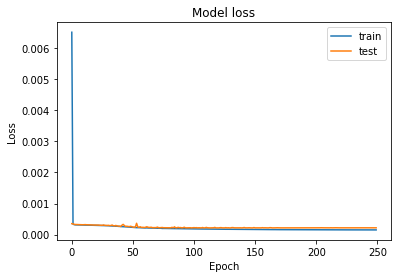

In [19]:
plot_loss(history)

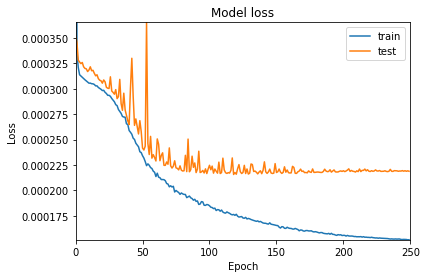

In [20]:
# Zoomed version of Model loss
plot_loss_tight(history)

## Predictions on Train / Test

In [21]:
dataset_1['radiance_predicted'] = model.predict(dataset_1['image'])[:,0]
dataset_2['radiance_predicted'] = model.predict(dataset_2['image'])[:,0]

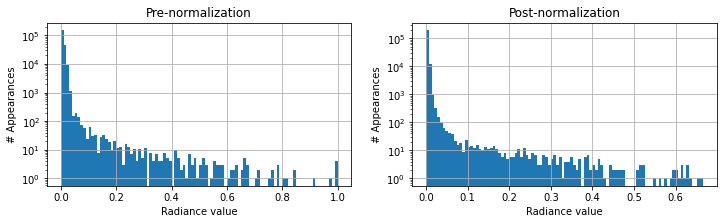

In [26]:
# Compare radiance distr
compare_radiance_histogram(dataset_1['radiance'], dataset_1['radiance_predicted'], 'Pre-normalization', 'Post-normalization')

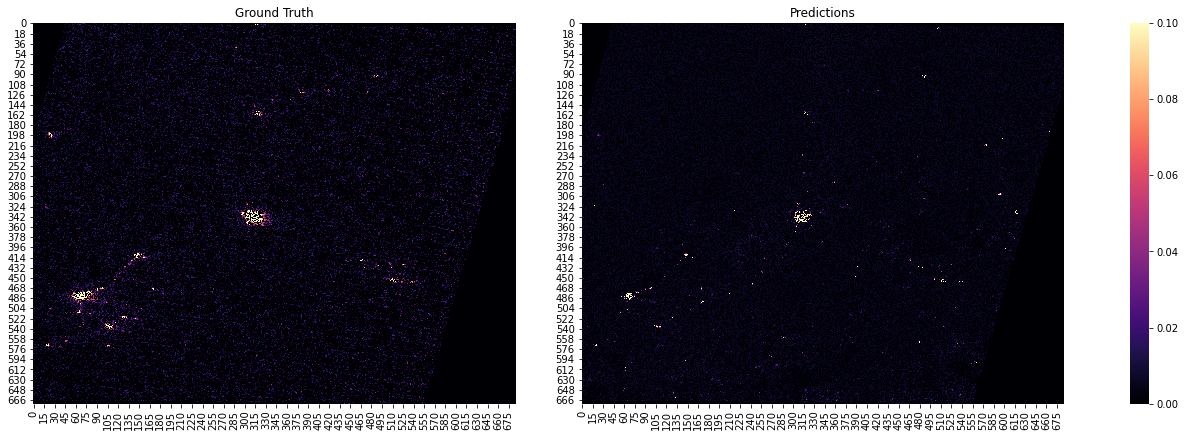

In [29]:
# Training dataset
compare_same_dataset(dataset=dataset_1,
                     sparse=True,
                     amplification=10.0)

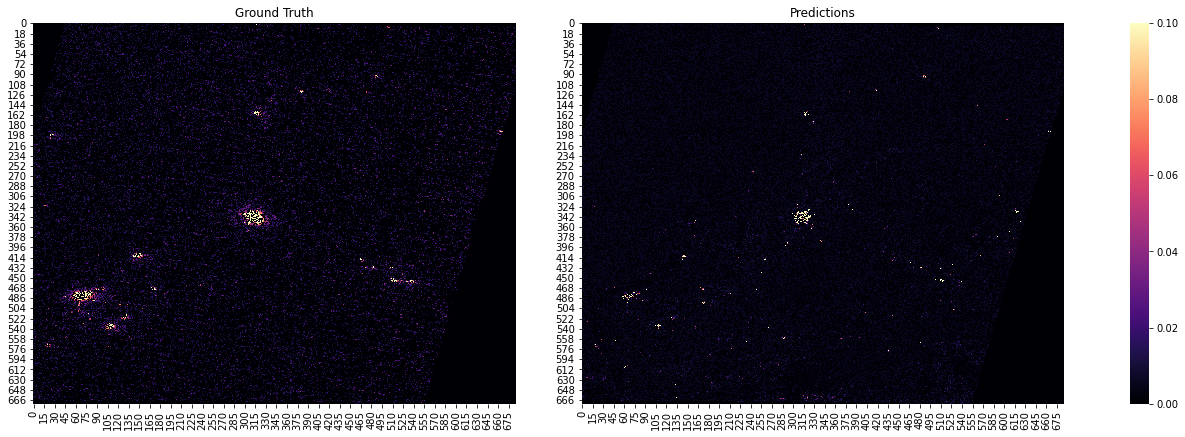

In [30]:
# Testing dataset
compare_same_dataset(dataset=dataset_2,
                     sparse=True,
                     amplification=10.0)

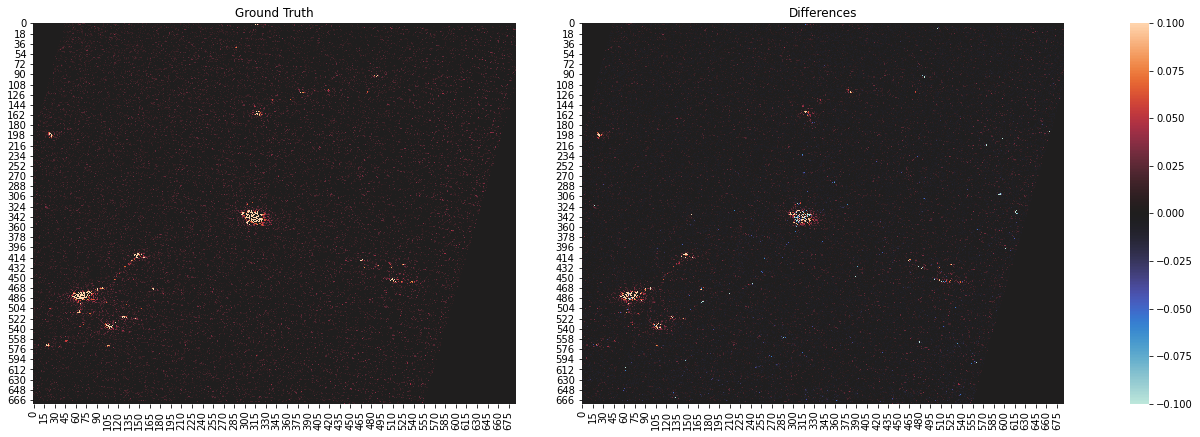

In [31]:
# Training dataset
compare_same_dataset(dataset=dataset_1,
                     pr_title='Differences',
                     vmin=-0.1,
                     vmax=0.1,
                     sparse=True,
                     diff=True,
                     cmap='icefire')

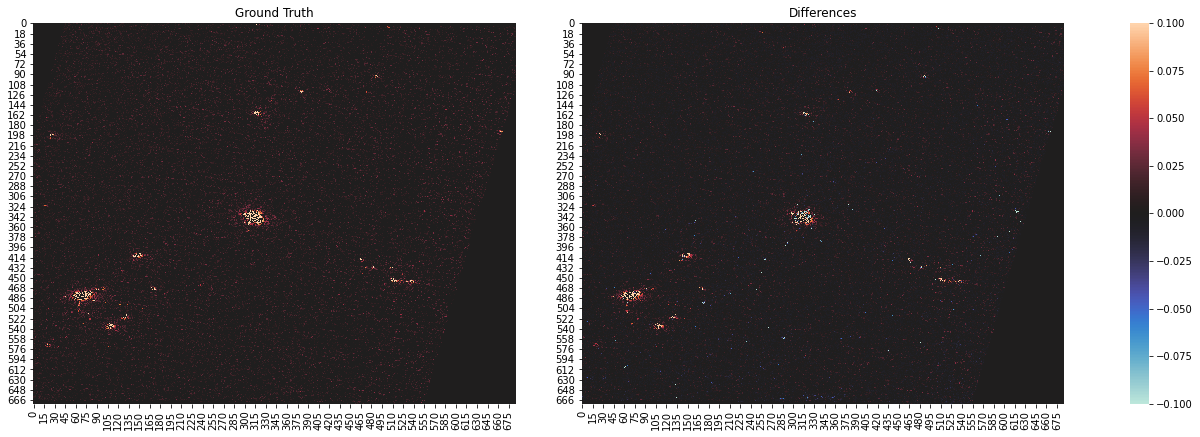

In [32]:
# Testing dataset
compare_same_dataset(dataset=dataset_2,
                     pr_title='Differences',
                     vmin=-0.1,
                     vmax=0.1,
                     sparse=True,
                     diff=True,
                     cmap='icefire')

In [54]:
def plot_diff(dataset, title="", lim=1.0):
    plt.scatter(dataset["radiance"], dataset["radiance_predicted"])
    
    line = np.arange(0.0, lim+0.01, 0.01)
    plt.plot(line, line, 'r',  label="Unit line")
    
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.title(title)
    
def show_diff(dataset, max_radiance, thresh_low, thresh_high):
    for data in dataset:
        if data['radiance'] * max_radiance <= thresh_low and data['radiance_predicted'] * max_radiance >= thresh_high:
            show_data(data, max_radiance)
            break

def count_diff(dataset, max_radiance, thresh_nolight, thresh_low, thresh_high=np.inf):
    count = 0
    
    for data in dataset:
        if data['radiance'] * max_radiance <= thresh_nolight:
            if data['radiance_predicted'] * max_radiance >= thresh_low and data['radiance_predicted'] * max_radiance < thresh_high:
                count += 1

    print(f'{count} tiles under {thresh_nolight} radiance were predicted to be above {thresh_low} radiance but below {thresh_high}')
            
            
def write_diff(dataset, title, max_radiance, thresh_nolight, thresh_low, thresh_high=np.inf):
    header = ['coordinates', 'radiance']
    count = 0
    
    with open(f'nolight_{model_name}_{title}_{thresh_nolight}_{thresh_low}.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for data in dataset:
            if data['radiance'] * max_radiance <= thresh_nolight:
                if data['radiance_predicted'] * max_radiance >= thresh_low and data['radiance_predicted'] * max_radiance < thresh_high:
                    count += 1
                    
                    vals = [f"{data['gps'][1]}N {data['gps'][0]}E", f"{round(data['radiance_predicted'] * max_radiance)}"]
                    writer.writerow(vals)
        print(f'{count} tiles under {thresh_nolight} radiance were predicted to be above {thresh_low} radiance but below {thresh_high}')

Training data:
Correlation: 0.7178320261682679, P-Value: 0.0


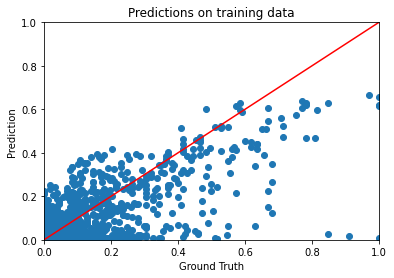

In [23]:
plot_diff(dataset_1, "Predictions on training data")
correlation, p_value = scipy.stats.pearsonr(dataset_1['radiance'],
                                            dataset_1['radiance_predicted'])
print(f'Training data:')
print(f'Correlation: {correlation}, P-Value: {p_value}')

Testing data:
Correlation: 0.5733536550682982, P-Value: 0.0


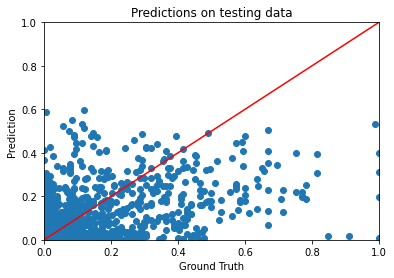

In [24]:
plot_diff(dataset_2, "Predictions on testing data")
correlation, p_value = scipy.stats.pearsonr(dataset_2['radiance'],
                                            dataset_2['radiance_predicted'])
print(f'Testing data:')
print(f'Correlation: {correlation}, P-Value: {p_value}')

In [51]:
write_diff(dataset_1, "train1", max_radiance, 3, 8)
write_diff(dataset_2, "test2", max_radiance, 3, 8)

163 tiles under 3 radiance were predicted to be above 8 radiance
183 tiles under 3 radiance were predicted to be above 8 radiance
